In [0]:
# Unmount the existing directory
dbutils.fs.unmount("/mnt/nyctaxi")


/mnt/nyctaxi has been unmounted.
Out[4]: True

In [0]:
# Set variables for mounting
storage_account_name = "q333"  # Replace with your storage account name
container_name = "mmmmmmm"  # Replace with your container name
sas_token = "sv=2022-11-02&ss=bfqt&srt=sco&sp=rwdlacupiytfx&se=2024-10-14T10:23:53Z&st=2024-10-13T02:23:53Z&spr=https&sig=Lv%2BlEUxmJ%2FMj4PdK1vuxWxBmzpM2JpjbWmMRDWluXzU%3D"

# Mount the Blob Storage container to Databricks
dbutils.fs.mount(
    source = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net",
    mount_point = "/mnt/nyctaxi",  # Specify your mount point here
    extra_configs = {f"fs.azure.sas.{container_name}.{storage_account_name}.blob.core.windows.net": sas_token}
)

# Verify the mount by listing files in the mounted container
display(dbutils.fs.ls("/mnt/nyctaxi"))


path,name,size,modificationTime
dbfs:/mnt/nyctaxi/yellow_tripdata_2015-01.parquet,yellow_tripdata_2015-01.parquet,175325767,1728784568000
dbfs:/mnt/nyctaxi/yellow_tripdata_2015-02.parquet,yellow_tripdata_2015-02.parquet,171639741,1728784567000
dbfs:/mnt/nyctaxi/yellow_tripdata_2015-03.parquet,yellow_tripdata_2015-03.parquet,185355459,1728784534000
dbfs:/mnt/nyctaxi/yellow_tripdata_2015-04.parquet,yellow_tripdata_2015-04.parquet,180491380,1728784540000
dbfs:/mnt/nyctaxi/yellow_tripdata_2015-05.parquet,yellow_tripdata_2015-05.parquet,182487456,1728784540000
dbfs:/mnt/nyctaxi/yellow_tripdata_2015-06.parquet,yellow_tripdata_2015-06.parquet,171760764,1728780212000
dbfs:/mnt/nyctaxi/yellow_tripdata_2015-07.parquet,yellow_tripdata_2015-07.parquet,160689531,1728780193000
dbfs:/mnt/nyctaxi/yellow_tripdata_2015-08.parquet,yellow_tripdata_2015-08.parquet,154240802,1728780192000
dbfs:/mnt/nyctaxi/yellow_tripdata_2015-09.parquet,yellow_tripdata_2015-09.parquet,156401569,1728780212000
dbfs:/mnt/nyctaxi/yellow_tripdata_2015-10.parquet,yellow_tripdata_2015-10.parquet,171091467,1728780212000


In [0]:
# Define the list of file paths
file_paths = [
    "/mnt/nyctaxi/yellow_tripdata_2015-01.parquet",
    "/mnt/nyctaxi/yellow_tripdata_2015-02.parquet",
    "/mnt/nyctaxi/yellow_tripdata_2015-03.parquet",
    "/mnt/nyctaxi/yellow_tripdata_2015-04.parquet",
    "/mnt/nyctaxi/yellow_tripdata_2015-05.parquet",
    "/mnt/nyctaxi/yellow_tripdata_2015-06.parquet",
    "/mnt/nyctaxi/yellow_tripdata_2015-07.parquet",
    "/mnt/nyctaxi/yellow_tripdata_2015-08.parquet",
    "/mnt/nyctaxi/yellow_tripdata_2015-09.parquet",
    "/mnt/nyctaxi/yellow_tripdata_2015-10.parquet",
    "/mnt/nyctaxi/yellow_tripdata_2015-11.parquet",
    "/mnt/nyctaxi/yellow_tripdata_2015-12.parquet"
]

# Initialize an empty DataFrame to hold all data
combined_df = None

# Loop over the file paths and read each Parquet file
for file_path in file_paths:
    monthly_df = spark.read.parquet(file_path)
    
    # Combine into one DataFrame
    if combined_df is None:
        combined_df = monthly_df
    else:
        combined_df = combined_df.union(monthly_df)

# Show the combined data
combined_df.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2015-01-01 00:11:33|  2015-01-01 00:16:48|              1|          1.0|         1|                 N|          41|         166|           1|        5.7|  0.5|    0.5|       1.

In [0]:
# Calculate fuel consumed and CO2 emissions
combined_df = combined_df.withColumn('fuel_consumed_gallons', combined_df['trip_distance'] / 22)
combined_df = combined_df.withColumn('co2_emissions_kg', combined_df['fuel_consumed_gallons'] * 8.89)

# Show the updated DataFrame with emissions
combined_df.select('trip_distance', 'fuel_consumed_gallons', 'co2_emissions_kg').show(5)


+-------------+---------------------+------------------+
|trip_distance|fuel_consumed_gallons|  co2_emissions_kg|
+-------------+---------------------+------------------+
|          1.0| 0.045454545454545456|0.4040909090909091|
|          0.9|  0.04090909090909091|0.3636818181818182|
|          3.5|   0.1590909090909091|1.4143181818181818|
|          2.1|  0.09545454545454546|0.8485909090909092|
|          1.0| 0.045454545454545456|0.4040909090909091|
+-------------+---------------------+------------------+
only showing top 5 rows



In [0]:
# Convert the correct pickup date column to a date type (using `tpep_pickup_datetime`)
from pyspark.sql.functions import to_date

# Use the correct column name `tpep_pickup_datetime`
combined_df = combined_df.withColumn('pickup_date', to_date(combined_df['tpep_pickup_datetime']))

# Group by day and sum the emissions
emissions_per_day = combined_df.groupBy('pickup_date').sum('co2_emissions_kg')

# Rename the column for clarity
emissions_per_day = emissions_per_day.withColumnRenamed('sum(co2_emissions_kg)', 'total_emissions')

# Show the emissions per day
emissions_per_day.show(5)


+-----------+--------------------+
|pickup_date|     total_emissions|
+-----------+--------------------+
| 2015-01-20|   456557.8989685449|
| 2015-01-24|  1828569.0920628353|
| 2015-01-23|1.2120625931295628E7|
| 2015-01-11|1.1846963206527313E7|
| 2015-01-10|  1211063.4933083628|
+-----------+--------------------+
only showing top 5 rows



In [0]:
# Filter rides with 1-2 passengers
group_1_df = combined_df.filter((combined_df['passenger_count'] == 1) | (combined_df['passenger_count'] == 2))

# Filter rides with 3 or more passengers
group_2_df = combined_df.filter(combined_df['passenger_count'] >= 3)

# Group and sum emissions per day for both groups
group_1_emissions = group_1_df.groupBy('pickup_date').sum('co2_emissions_kg').withColumnRenamed('sum(co2_emissions_kg)', 'group_1_emissions')
group_2_emissions = group_2_df.groupBy('pickup_date').sum('co2_emissions_kg').withColumnRenamed('sum(co2_emissions_kg)', 'group_2_emissions')

# Join the two groups to compare
emissions_comparison = group_1_emissions.join(group_2_emissions, 'pickup_date')

# Show the comparison
emissions_comparison.show(5)


+-----------+--------------------+------------------+
|pickup_date|   group_1_emissions| group_2_emissions|
+-----------+--------------------+------------------+
| 2015-01-20|   390835.4220593965|65431.543577273194|
| 2015-01-24|  1748137.2736856367| 80110.72774091322|
| 2015-01-23|1.2043507213873684E7| 76773.38133182067|
| 2015-01-11|1.1765422267709123E7|  81433.0869545478|
| 2015-01-10|    1121122.07829954| 89773.27278182226|
+-----------+--------------------+------------------+
only showing top 5 rows



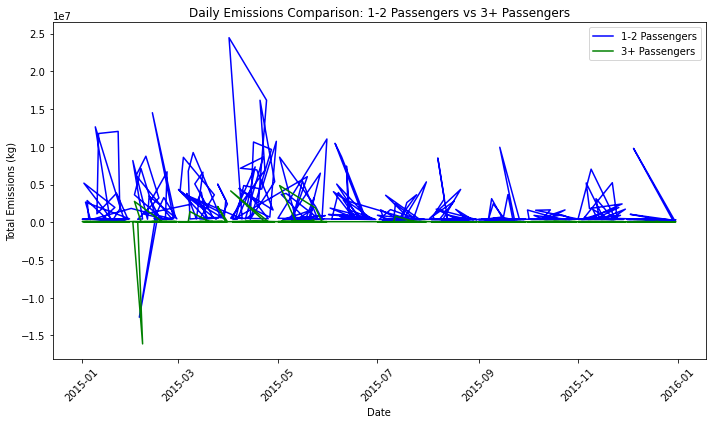

In [0]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for easy plotting
emissions_pdf = emissions_comparison.toPandas()

# Plot emissions
plt.figure(figsize=(10, 6))
plt.plot(emissions_pdf['pickup_date'], emissions_pdf['group_1_emissions'], label='1-2 Passengers', color='blue')
plt.plot(emissions_pdf['pickup_date'], emissions_pdf['group_2_emissions'], label='3+ Passengers', color='green')
plt.xlabel('Date')
plt.ylabel('Total Emissions (kg)')
plt.title('Daily Emissions Comparison: 1-2 Passengers vs 3+ Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [0]:
# Load the parquet files into a DataFrame
df = spark.read.parquet("dbfs:/mnt/nyctaxi/")


In [0]:
# Show the schema to inspect the data
df.printSchema()

# View the first few rows
df.show(5)


root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)
 |-- airport_fee: integer (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+-

In [0]:
# Rename columns to match your code logic if necessary
df = df.withColumnRenamed('tpep_pickup_datetime', 'pickup_datetime')


In [0]:
# Calculate fuel consumed and CO2 emissions for each trip
df = df.withColumn('fuel_consumed_gallons', df['trip_distance'] / 22)
df = df.withColumn('co2_emissions_kg', df['fuel_consumed_gallons'] * 8.89)

# Display the results
df.select('trip_distance', 'fuel_consumed_gallons', 'co2_emissions_kg').show(5)


+-------------+---------------------+------------------+
|trip_distance|fuel_consumed_gallons|  co2_emissions_kg|
+-------------+---------------------+------------------+
|          1.0| 0.045454545454545456|0.4040909090909091|
|          0.9|  0.04090909090909091|0.3636818181818182|
|          3.5|   0.1590909090909091|1.4143181818181818|
|          2.1|  0.09545454545454546|0.8485909090909092|
|          1.0| 0.045454545454545456|0.4040909090909091|
+-------------+---------------------+------------------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import when
from pyspark.sql.functions import when

# Add a new column to categorize passenger groups
df = df.withColumn('passenger_group', 
                   when(df['passenger_count'] <= 2, '1-2 Passengers')
                   .otherwise('3+ Passengers'))

# Group by passenger group and date, and calculate total emissions per day
emissions_per_day = df.groupBy('pickup_datetime', 'passenger_group') \
                      .agg({'co2_emissions_kg': 'sum'}) \
                      .withColumnRenamed('sum(co2_emissions_kg)', 'total_emissions_kg')

# Show the results
emissions_per_day.show(5)


+-------------------+---------------+------------------+
|    pickup_datetime|passenger_group|total_emissions_kg|
+-------------------+---------------+------------------+
|2015-01-01 00:39:02| 1-2 Passengers|           14.0462|
|2015-01-01 00:13:43| 1-2 Passengers| 9.758795454545456|
|2015-01-01 00:20:56| 1-2 Passengers|10.154804545454544|
|2015-01-01 00:39:50| 1-2 Passengers|12.308609090909094|
|2015-01-01 00:23:46| 1-2 Passengers|1.8830636363636364|
+-------------------+---------------+------------------+
only showing top 5 rows



In [0]:
# Convert to Pandas DataFrame
emissions_per_day_pandas = emissions_per_day.toPandas()


In [0]:
# Rename columns to match the expected names (adjust based on actual column names)
emissions_per_day = emissions_per_day.withColumnRenamed('date_column_in_data', 'pickup_date')
# Convert Spark DataFrame to Pandas DataFrame
emissions_per_day_pandas = emissions_per_day.toPandas()

# Check the Pandas DataFrame
print(emissions_per_day_pandas.head())



      pickup_datetime passenger_group  total_emissions_kg
0 2015-01-01 00:39:02  1-2 Passengers           14.046200
1 2015-01-01 00:13:43  1-2 Passengers            9.758795
2 2015-01-01 00:20:56  1-2 Passengers           10.154805
3 2015-01-01 00:39:50  1-2 Passengers           12.308609
4 2015-01-01 00:23:46  1-2 Passengers            1.883064


In [0]:
# Print schema to check if 'pickup_date' exists
emissions_per_day.printSchema()

# Show a sample of data to check if 'pickup_date', 'total_emissions_kg', and 'passenger_group' exist
emissions_per_day.show(5)



root
 |-- pickup_datetime: timestamp (nullable = true)
 |-- passenger_group: string (nullable = false)
 |-- total_emissions_kg: double (nullable = true)

+-------------------+---------------+------------------+
|    pickup_datetime|passenger_group|total_emissions_kg|
+-------------------+---------------+------------------+
|2015-01-01 00:39:02| 1-2 Passengers|           14.0462|
|2015-01-01 00:13:43| 1-2 Passengers| 9.758795454545456|
|2015-01-01 00:20:56| 1-2 Passengers|10.154804545454544|
|2015-01-01 00:39:50| 1-2 Passengers|12.308609090909094|
|2015-01-01 00:23:46| 1-2 Passengers|1.8830636363636364|
+-------------------+---------------+------------------+
only showing top 5 rows



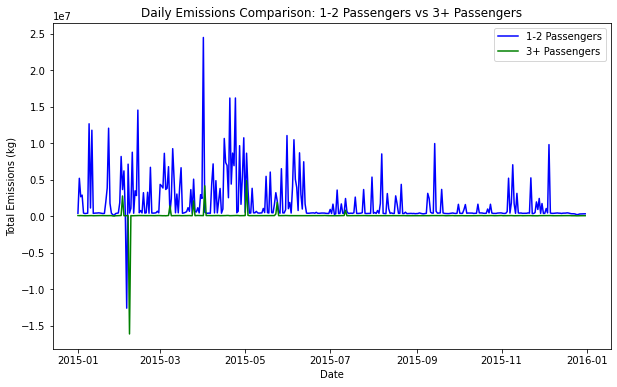

In [0]:
# Import required libraries
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Group data by passenger group and pickup datetime (date)
emissions_per_day = df.groupBy(df['pickup_datetime'].cast('date').alias('pickup_date'), 'passenger_group') \
    .agg(F.sum('co2_emissions_kg').alias('total_emissions_kg')) \
    .orderBy('pickup_date')

# Convert to pandas dataframe
emissions_per_day_pandas = emissions_per_day.toPandas()

# Create a plot
plt.figure(figsize=(10, 6))
for group, color in zip(emissions_per_day_pandas['passenger_group'].unique(), ['blue', 'green']):
    subset = emissions_per_day_pandas[emissions_per_day_pandas['passenger_group'] == group]
    plt.plot(subset['pickup_date'], subset['total_emissions_kg'], label=group, color=color)

plt.xlabel('Date')
plt.ylabel('Total Emissions (kg)')
plt.title('Daily Emissions Comparison: 1-2 Passengers vs 3+ Passengers')
plt.legend()
plt.show()



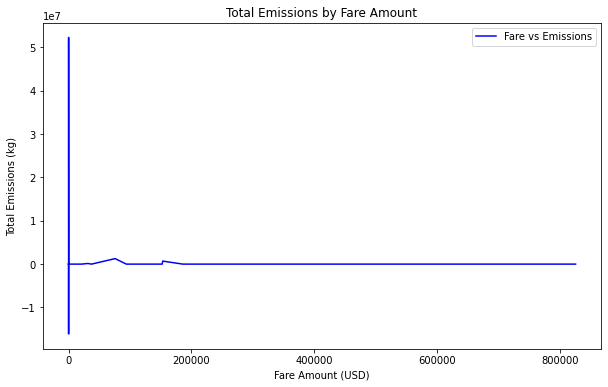

In [0]:
# Aggregate emissions by fare amount ranges
df_fare_analysis = df.groupBy('fare_amount').agg(F.sum('co2_emissions_kg').alias('total_emissions_kg')).orderBy('fare_amount')

# Convert to pandas and plot
fare_analysis_pandas = df_fare_analysis.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fare_analysis_pandas['fare_amount'], fare_analysis_pandas['total_emissions_kg'], color='blue', label='Fare vs Emissions')
plt.title('Total Emissions by Fare Amount')
plt.xlabel('Fare Amount (USD)')
plt.ylabel('Total Emissions (kg)')
plt.legend()
plt.show()


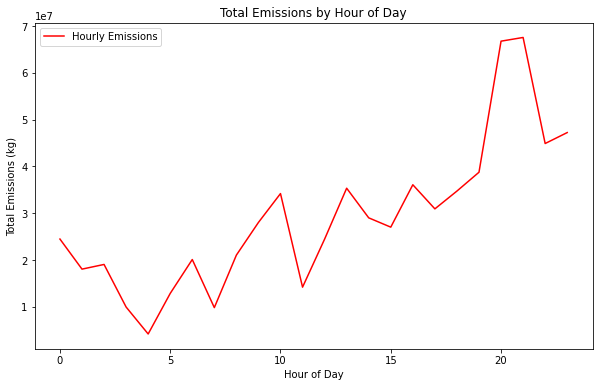

In [0]:
from pyspark.sql.functions import hour
#peakemissionhours

# Extract hour from pickup_datetime
df = df.withColumn('pickup_hour', hour(df['pickup_datetime']))

# Group by pickup hour and sum emissions
df_hourly_emissions = df.groupBy('pickup_hour').agg(F.sum('co2_emissions_kg').alias('total_emissions_kg')).orderBy('pickup_hour')

# Convert to pandas and plot
hourly_emissions_pandas = df_hourly_emissions.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(hourly_emissions_pandas['pickup_hour'], hourly_emissions_pandas['total_emissions_kg'], color='red', label='Hourly Emissions')
plt.title('Total Emissions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Emissions (kg)')
plt.legend()
plt.show()


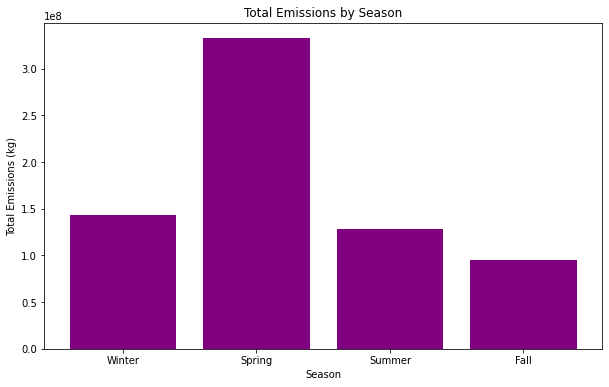

In [0]:
from pyspark.sql.functions import month

# Create a season column based on the month
df = df.withColumn('season', 
                   F.when(month(df['pickup_datetime']).isin(12, 1, 2), 'Winter')
                   .when(month(df['pickup_datetime']).isin(3, 4, 5), 'Spring')
                   .when(month(df['pickup_datetime']).isin(6, 7, 8), 'Summer')
                   .when(month(df['pickup_datetime']).isin(9, 10, 11), 'Fall'))

# Group by season and calculate total emissions
df_seasonal_emissions = df.groupBy('season').agg(F.sum('co2_emissions_kg').alias('total_emissions_kg'))

# Convert to pandas and plot
seasonal_emissions_pandas = df_seasonal_emissions.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(seasonal_emissions_pandas['season'], seasonal_emissions_pandas['total_emissions_kg'], color='purple')
plt.title('Total Emissions by Season')
plt.xlabel('Season')
plt.ylabel('Total Emissions (kg)')
plt.show()


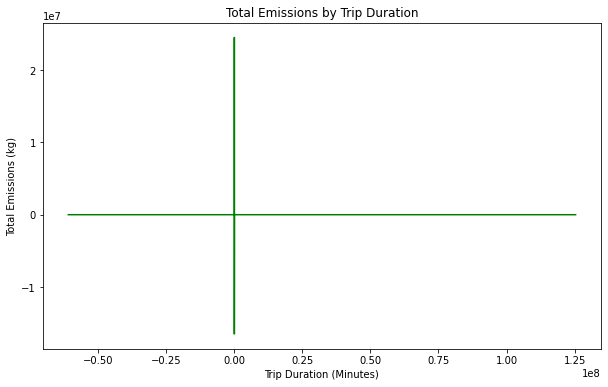

In [0]:
from pyspark.sql.functions import unix_timestamp

# Calculate trip duration in minutes
df = df.withColumn('trip_duration_minutes', 
                   (unix_timestamp(df['tpep_dropoff_datetime']) - unix_timestamp(df['pickup_datetime'])) / 60)

# Group by trip duration and calculate total emissions
df_duration_emissions = df.groupBy('trip_duration_minutes').agg(F.sum('co2_emissions_kg').alias('total_emissions_kg')).orderBy('trip_duration_minutes')

# Convert to pandas and plot
duration_emissions_pandas = df_duration_emissions.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(duration_emissions_pandas['trip_duration_minutes'], duration_emissions_pandas['total_emissions_kg'], color='green')
plt.title('Total Emissions by Trip Duration')
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Total Emissions (kg)')
plt.show()
